# 1.Spatially constrained clustering (SCC) with binnning data

This notebook demonstrates how to perform basic clustering on a raw anndata object (spatial transcriptomic data) 
using spateo and SCC clustering.

Binning anndata object can be obtained with spateo.io functions from multiple spatial transcriptomic assays. 
(See the docs for spateo.io)

## Packages

In [1]:
import spateo as st
import dynamo as dyn

2024-10-10 04:02:12.221487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 04:02:12.234480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 04:02:12.238433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 04:02:12.916405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


alphashape is not installed. Please install it using 'pip install alphashape'.
fastpd is not installed. If you need mesh correction, please compile the fastpd library.


## Data source
**bin60_h5ad:** https://www.dropbox.com/s/c5tu4drxda01m0u/mousebrain_bin60.h5ad?dl=0


In [ ]:
# Load binning data
fname_bin60 = "mousebrain_bin60.h5ad"
adata_bin60 = st.sample_data.mousebrain(fname_bin60)
adata_bin60

## Normalization & Dimensional reduction

In [ ]:
# Preprocessing
st.pp.filter.filter_genes(adata_bin60, min_cells=3, inplace=True)

# Normalization
dyn.pp.normalize_cell_expr_by_size_factors(adata_bin60, layers="X")

# Linear reduction
st.tl.pca_spateo(adata_bin60, n_pca_components=30)

# Identify neighbors(KNN)
dyn.tl.neighbors(adata_bin60, n_neighbors=30)

In [2]:
adata_bin60=st.read('data/test.h5ad')

## Vanilla louvain clustering

|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----? louvain is not maintained, we recommend using leiden instead.
|-----> [Community clustering with louvain] completed [1.5006s]


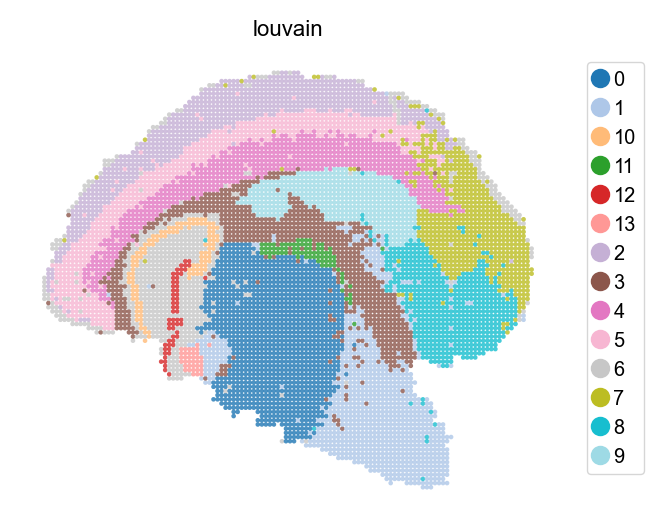

In [3]:
#louvain clustering
dyn.tl.louvain(adata_bin60, resolution=1)
st.pl.space(adata_bin60, color=['louvain'], show_legend="upper left", 
            figsize=(4, 3), color_key_cmap="tab20")


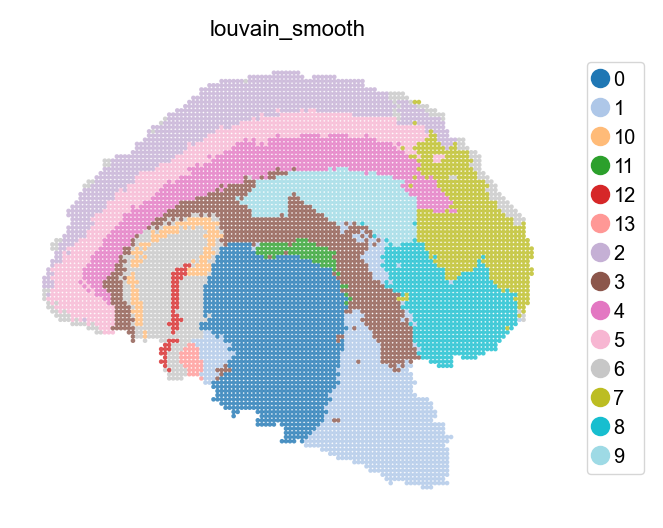

In [4]:
adata_bin60.obs['louvain_smooth']=st.tl.smooth(adata_bin60, radius=5, key='louvain')
st.pl.space(adata_bin60, color=['louvain_smooth'], show_legend="upper left", 
            figsize=(4, 3), color_key_cmap="tab20")

## Spatially constrained clustering (SCC)

The SCC clustering function is implemented based on basic clustering methods (e.g. louvain, leiden, ...), 
by replacing the input K-nearest neighbor(KNN) network, with the fusion of KNN and spatial neighbor network.

We adjust the computational weight of spatial nearness by adjusting the s_neigh argument. Typically, we set 
s_neigh according to the spatial arrangement of spots (i.e. the assay we use). For example, s_neigh could 
be 4, 8, 12, etc, in a squared array sequencing platform (such as Stereo-seq, ...), and could be 6, 18, etc, 
in a hexagon platform (such as Visium, ...). Larger s_neigh brings larger weight for spatial information, while 
we do not recommend setting s_neigh too big.


|-----> <insert> expression_connectivities to obsp in AnnData Object.
|-----> <insert> expression_distances to obsp in AnnData Object.
|-----> <insert> expression_neighbors to uns in AnnData Object.
|-----> <insert> expression_neighbors.indices to uns in AnnData Object.
|-----> <insert> expression_neighbors.params to uns in AnnData Object.
|-----> <insert> spatial_distances to obsp in AnnData Object.
|-----> <insert> spatial_connectivities to obsp in AnnData Object.
|-----> <insert> spatial_neighbors to uns in AnnData Object.
|-----> <insert> spatial_neighbors.indices to uns in AnnData Object.
|-----> <insert> spatial_neighbors.params to uns in AnnData Object.
|-----> using adj_matrix from arg for clustering...
|-----------> Converting graph_sparse_matrix to igraph object
|-----> [Community clustering with louvain] in progress: 100.0000%
|-----> [Community clustering with louvain] finished [429.8692s]


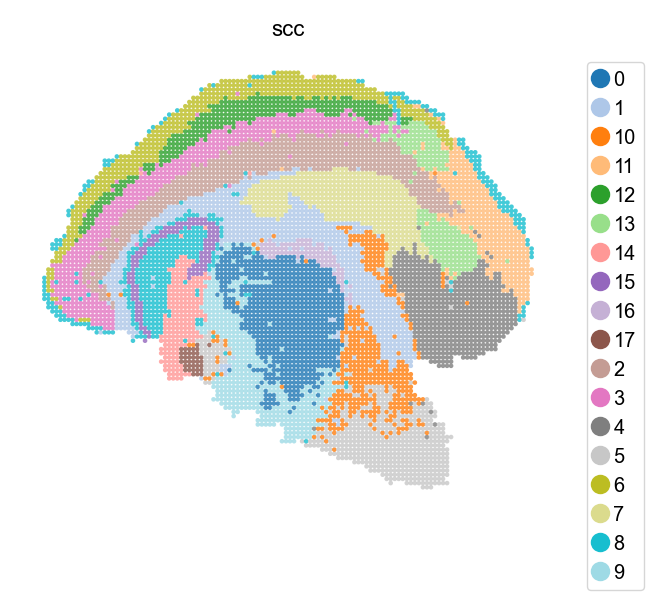

In [16]:
#scc clustering
st.tl.scc(
    adata_bin60,
    s_neigh=8,
    e_neigh=30,
    resolution=2,
    cluster_method="louvain",
    key_added="scc",
    pca_key="pca",
)
st.pl.space(adata_bin60, color=['scc'], show_legend="upper left", 
            figsize=(4, 3), color_key_cmap="tab20")

|-----> Optimizing the label by majority voting in the neighborhood.


100%|██████████| 7765/7765 [00:02<00:00, 3750.68it/s]

|-----> Finish smoothing the label. The new label is stored in adata.obs['label_smooth']


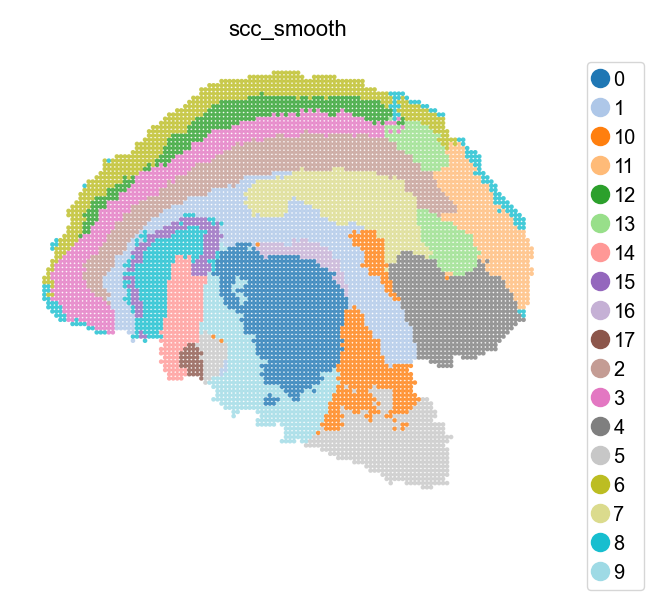

In [17]:
adata_bin60.obs['scc_smooth']=st.tl.smooth(adata_bin60, radius=10, key='scc')
st.pl.space(adata_bin60, color=['scc_smooth'], show_legend="upper left", 
            figsize=(4, 3), color_key_cmap="tab20")

## SCC clusters annotation

In [21]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'DORsm',
     '1': 'Fiber tracts',
     '2': 'Iso cortex L6',
     '3': 'Iso cortex L5',
     '4': 'AMY',
     '5': 'HY',
     '6': 'Iso cortex L2/3',
     '7': 'STRd',
     '8': 'HIP & CTXpl L1',
     '9': 'DORpm',
     '10': 'PAL',
     '11': 'OLF',
     '12': 'Iso cortex L4',
     '13': 'CTXsp',
     '14': 'DG',
     '15': 'CA',
     '16': 'RT',
     '17': 'VS',
}
adata_bin60.obs['scc_anno'] = adata_bin60.obs['scc_smooth'].map(cluster2annotation).astype('category')

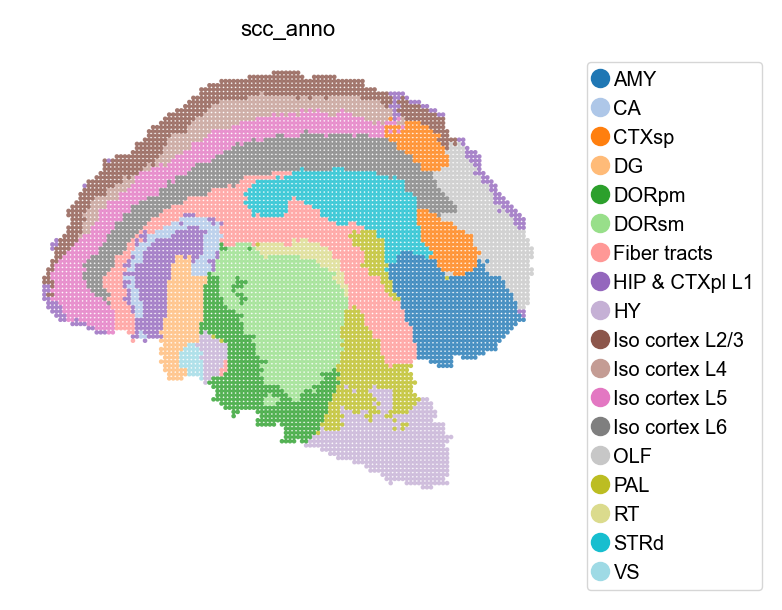

In [22]:
st.pl.space(
    adata_bin60,
    color=['scc_anno'],
    show_legend="upper left",
    figsize=(4, 3),
    color_key_cmap="tab20"
)

In [8]:
adata_bin60.write("mousebrain_bin60_clustered.h5ad", compression="gzip")

## STAGATE Clustering.

STAGATE learns low-dimensional latent embeddings with both spatial information and gene expressions via a graph attention auto-encoder. The method adopts an attention mechanism in the middle layer of the encoder and decoder, which adaptively learns the edge weights of spatial neighbor networks, and further uses them to update the spot representation by collectively aggregating information from its neighbors. The latent embeddings and the reconstructed expression profiles can be used to downstream tasks such as spatial domain identification, visualization, spatial trajectory inference, data denoising and 3D expression domain extraction.

Dong, K., Zhang, S. Deciphering spatial domains from spatially resolved transcriptomics with an adaptive graph attention auto-encoder. Nat Commun 13, 1739 (2022). https://doi.org/10.1038/s41467-022-29439-6

> Note
> 
> If you want to try STAGATE, you need to install [pytorch-geometric](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html).

In [3]:
import numpy as np
st.pp.select_hvf_seurat(adata_bin60,n_top= 2000,)
adata_bin60.raw=adata_bin60.copy()
adata_bin60=adata_bin60[:,adata_bin60.var['highly_variable_features']==True]

|-----> Using Seurat method to select highly variable features
|-----------> Start to calculate the top {n_top} highly variable genes
|-----> [Calculated the hvf seurat] in progress: 100.0000%
|-----> [Calculated the hvf seurat] finished [11.9451s]


------Calculating spatial graph...
The graph contains 40734 edges, 1252 cells.
32.5351 neighbors per cell on average.
------Calculating spatial graph...


/mnt/home/zehuazeng/software/rsc/lib/python3.10/site-packages/spateo/external/STAGATE_pyG/utils.py:108: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



The graph contains 48278 edges, 1461 cells.
33.0445 neighbors per cell on average.
------Calculating spatial graph...


/mnt/home/zehuazeng/software/rsc/lib/python3.10/site-packages/spateo/external/STAGATE_pyG/utils.py:108: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



The graph contains 44768 edges, 1355 cells.
33.0391 neighbors per cell on average.
------Calculating spatial graph...


/mnt/home/zehuazeng/software/rsc/lib/python3.10/site-packages/spateo/external/STAGATE_pyG/utils.py:108: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



The graph contains 43562 edges, 1315 cells.
33.1270 neighbors per cell on average.
------Calculating spatial graph...


/mnt/home/zehuazeng/software/rsc/lib/python3.10/site-packages/spateo/external/STAGATE_pyG/utils.py:108: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



The graph contains 47878 edges, 1474 cells.
32.4817 neighbors per cell on average.
------Calculating spatial graph...


/mnt/home/zehuazeng/software/rsc/lib/python3.10/site-packages/spateo/external/STAGATE_pyG/utils.py:108: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



The graph contains 39352 edges, 1200 cells.
32.7933 neighbors per cell on average.
------Calculating spatial graph...


/mnt/home/zehuazeng/software/rsc/lib/python3.10/site-packages/spateo/external/STAGATE_pyG/utils.py:108: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



The graph contains 269188 edges, 7765 cells.
34.6668 neighbors per cell on average.


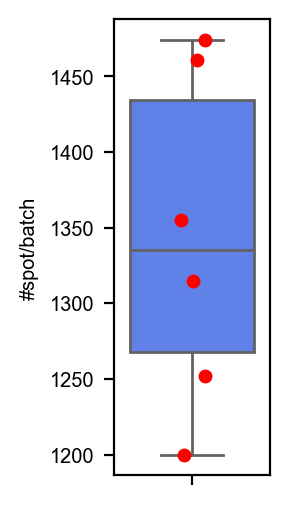

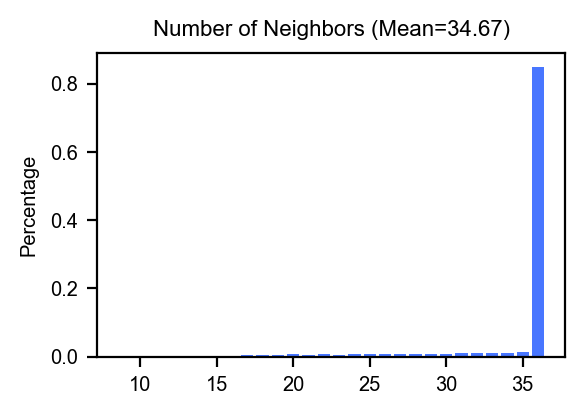

In [5]:
STA_obj=st.tl.pySTAGATE(adata_bin60,num_batch_x=3,num_batch_y=2,basis='spatial',
                 spatial_key=['X','Y'],rad_cutoff=200,num_epoch = 1000,lr=0.001,
                weight_decay=1e-4,hidden_dims = [512, 30],
                device='cuda:0')

In [6]:
STA_obj.train()
STA_obj.predicted()

100%|██████████| 1000/1000 [00:44<00:00, 22.61it/s]


The STAGATE representation values are stored in adata.obsm["STAGATE"].
The rex values are stored in adata.layers["STAGATE_ReX"].


Here, we implemented mclust from the R language using Python. We provide the same parameters as mclust for analysis. It should be noted that if an error occurs with `modelNames`=`EEV`, you can manually change it to `modelNames`=`EEE`.

In [13]:
st.tl.mclust_py(adata_bin60,use_rep='STAGATE',n_components=15,
                 modelNames='EEV', 
                )
adata_bin60.obs['mclust_STAGATE'] = st.tl.smooth(adata_bin60, radius=5, key='mclust') 

|-----> running GaussianMixture clustering
|-----> [GaussianMixture clustering] in progress: 100.0000%
|-----> [GaussianMixture clustering] finished [137.4638s]
|-----> Adding the cluster labels to adata.obs['mclust']
|-----> Optimizing the label by majority voting in the neighborhood.


100%|██████████| 7765/7765 [00:02<00:00, 3763.33it/s]

|-----> Finish smoothing the label. The new label is stored in adata.obs['label_smooth']


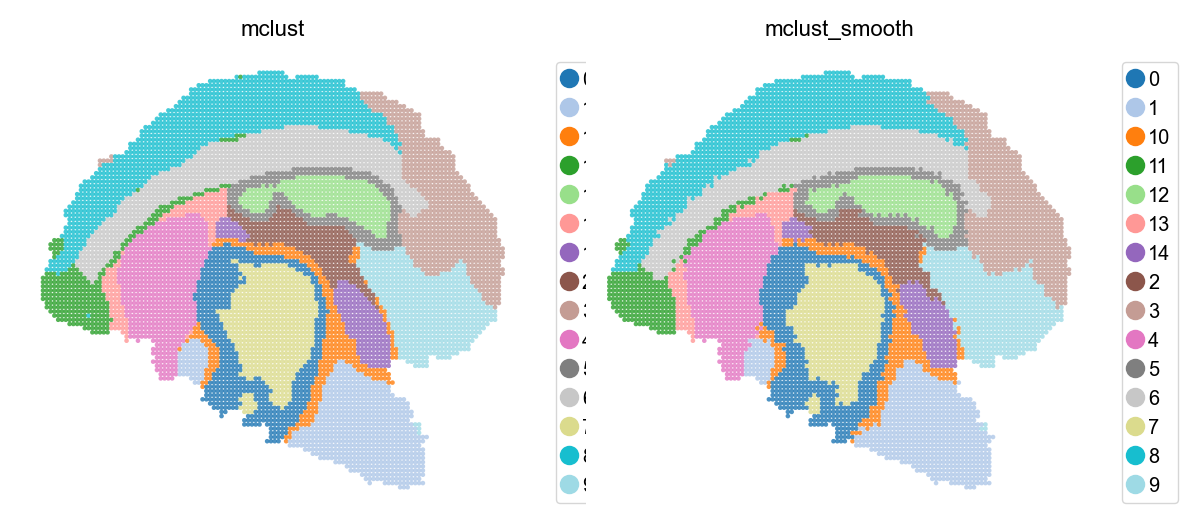

In [15]:
st.pl.space(adata_bin60, color=['mclust','mclust_smooth'], show_legend="upper left", 
            figsize=(4, 3), color_key_cmap="tab20")

## CAST Clustering

CAST is a Python library for physically aligning different spatial transcriptome regardless of technologies, magnification, individual variation, and experimental batch effects. CAST is composed of three modules: CAST Mark, CAST Stack, and CAST Projection.

Tang, Z., Luo, S., Zeng, H. et al. Search and match across spatial omics samples at single-cell resolution. Nat Methods (2024). https://doi.org/10.1038/s41592-024-02410-7

> Note
>
> If you want to use CAST, you need to install [dgl](https://www.dgl.ai/pages/start.html) 

|-----> running CAST
|-----------> Get the coordinates and expression data for each sample
Constructing delaunay graphs for 1 samples...
Training on cuda:0...


Loss: -442.843 step time=0.127s: 100%|██████████| 400/400 [00:49<00:00,  8.01it/s]


Finished.
The embedding, log, model files were saved to output/CAST_Mark
|-----> [CAST] in progress: 100.0000%
|-----> [CAST] finished [182.9659s]


100%|██████████| 1/1 [00:00<00:00, 12.57it/s]

|-----------> CAST embedding is saved in adata.obsm['X_cast']


|-----------> CAST clusters using kmeans are saved in adata.obs['CAST_clusters']


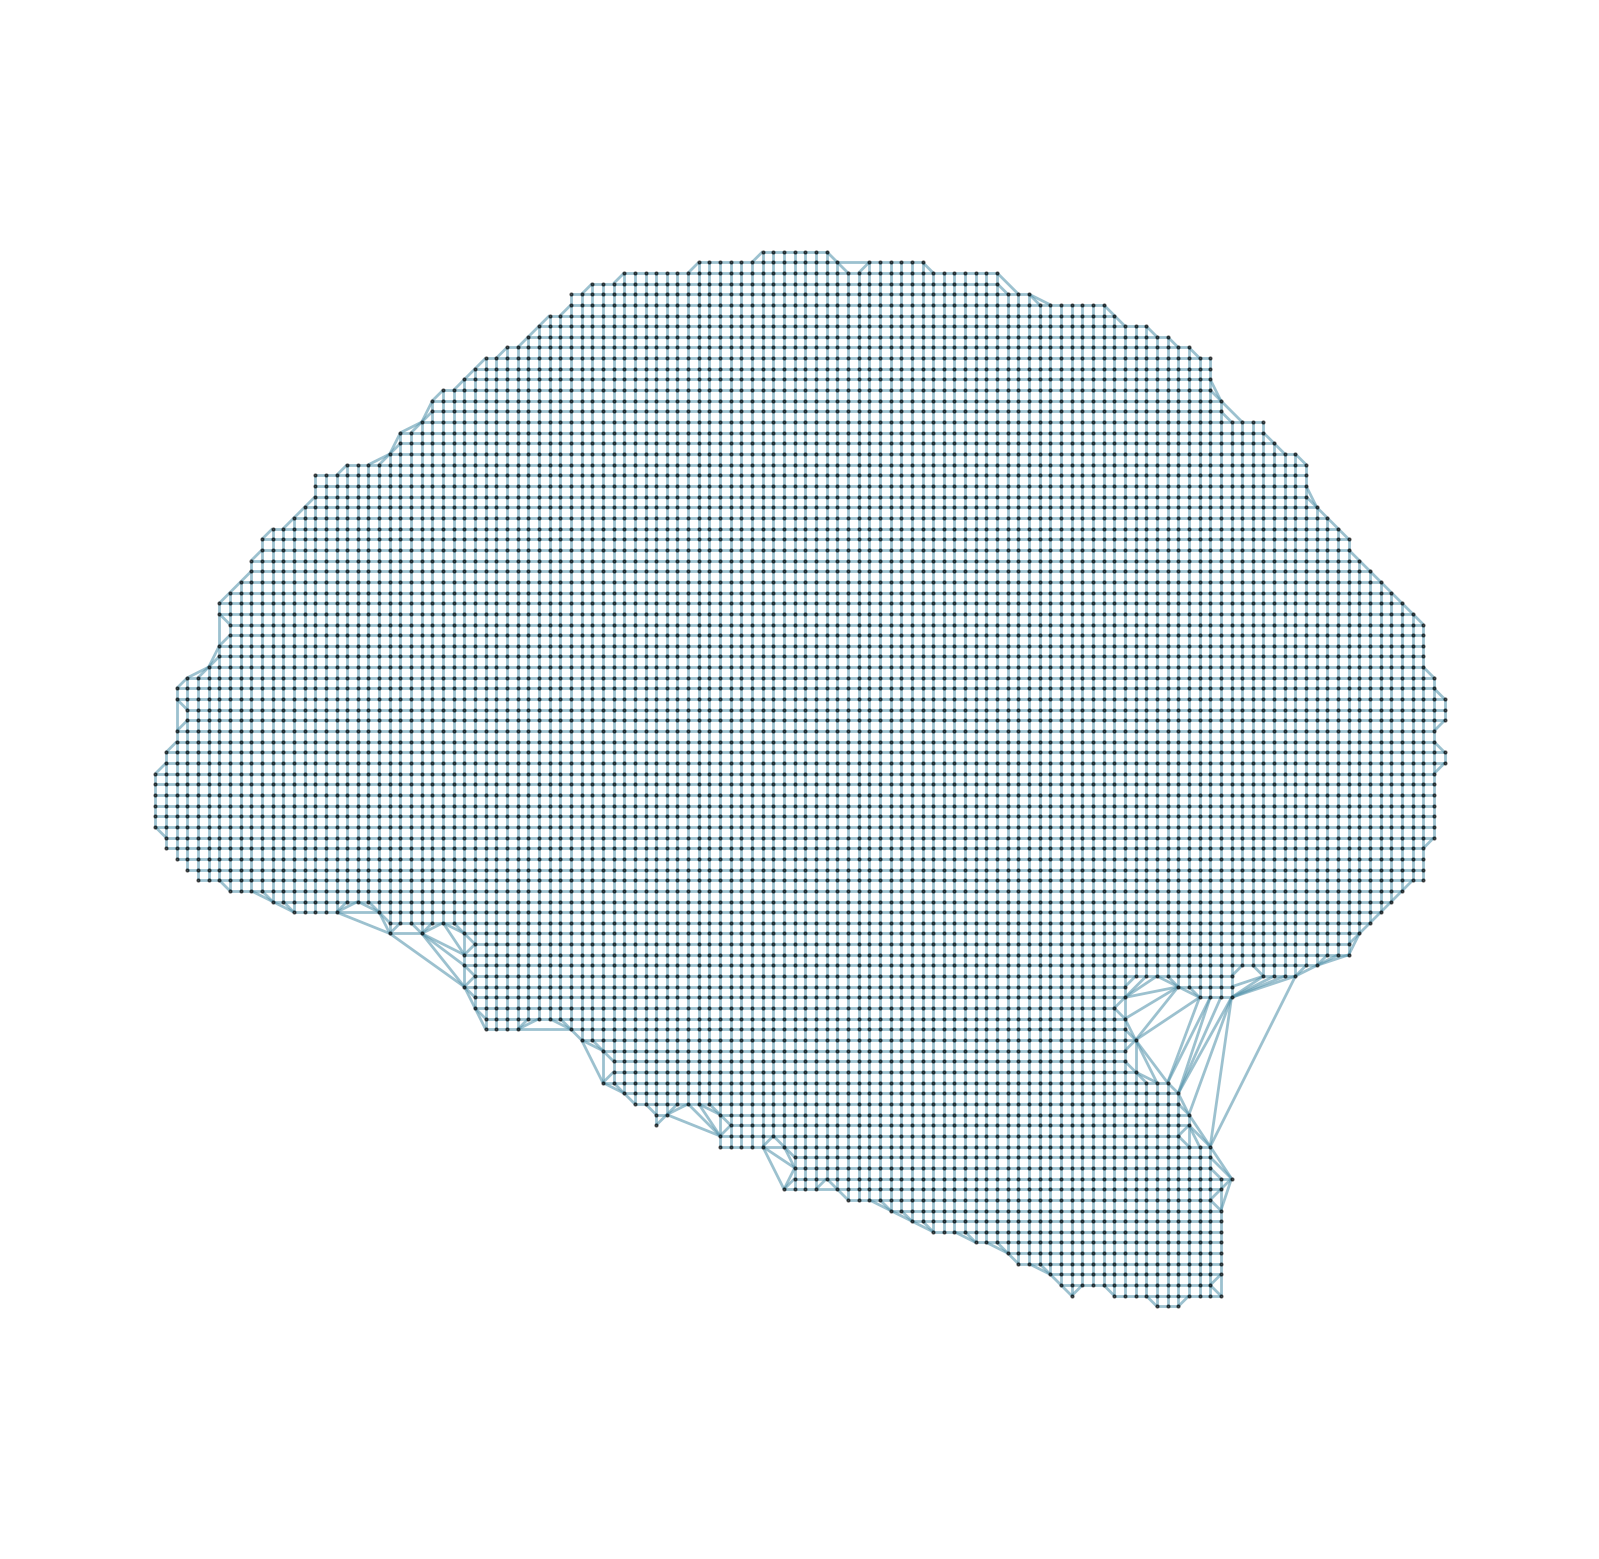

In [5]:
adata_bin60.obs['sample']='sample1'
adata_bin60.layers['norm_1e4']=adata_bin60.X.toarray()
st.tl.CAST(adata_bin60,sample_key='sample',basis='spatial',layer='norm_1e4',n_components=20,
        output_path = 'output/CAST_Mark',gpu_t=0,device='cuda:0')

In [3]:
st.tl.kmeans_clustering(adata_bin60,n_clusters=20, use_rep='X_cast', random_state=42,
                      cluster_key='CAST_clusters')

|-----> running KMeans clustering
|-----------> Get the coordinates and expression data
|-----------> KMeans clusters are saved in adata.obs['CAST_clusters']


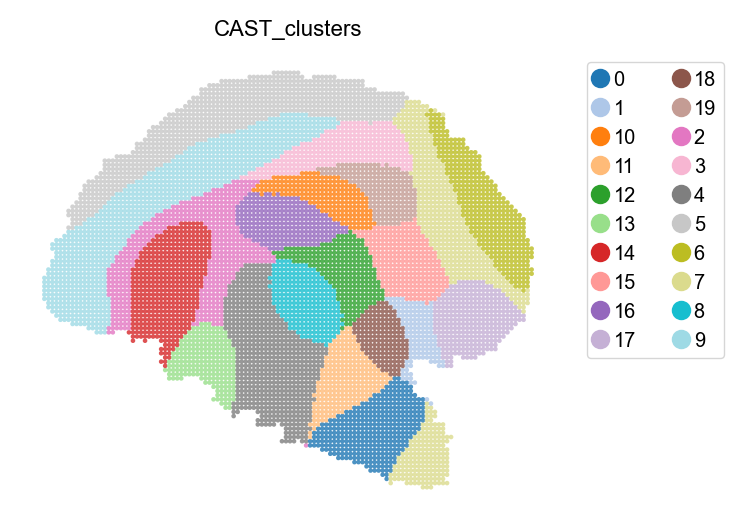

In [4]:
st.pl.space(adata_bin60, color=['CAST_clusters'], show_legend="upper left", 
            figsize=(4, 3), color_key_cmap="tab20")